In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
%cd ..

/Users/massil/repos/newsvendor_tester


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from environment import *
from algorithms.ddm import DDM_algorithm
from algorithms.rcosd_adaptive_volume_constrained import RCOSD_Adaptive_Volume_Constrained_algorithm
from algorithms.rcosd_variant_volume_constrained import RCOSD_Variant_Volume_Constrained_algorithm
from algorithms.cosd_variant2_volume_constrained import COSD_Variant2_Volume_Constrained_algorithm
from algorithms.osd_dynamic_projection_volume_constrained import OSD_Dynamic_Projection_Volume_Constrained_algorithm
from algorithms.cosd_adaptive_volume_constrained import COSD_Adaptive_Volume_Constrained_algorithm
from algorithms.rcosd_generic import RCOSD_generic_algorithm
from simulator import Simulator

In [3]:
nb_products = 50
horizon = 1_000
holding_costs = np.ones(nb_products)
penalty_costs = 50*np.ones(nb_products)

intensities = 2*np.random.rand(nb_products)
def env_generator() :
    demands = np.zeros((horizon+1,nb_products))
    for i in range(nb_products) :
        demands[1:,i] = scipy.stats.lognorm(s=intensities[i]).rvs(size=(horizon))
    return Environment_NonPerishable_Newsvendor(demands, holding_costs, penalty_costs)

In [4]:
quantile_sum = 0
for i in range(nb_products) :
    quantile = scipy.stats.lognorm(s=intensities[i]).ppf(penalty_costs[i]/(holding_costs[i]+penalty_costs[i]))
    quantile_sum += quantile
    print("Product {}: critical ratio {}, critical quantile {}".format(i,
        penalty_costs[i]/(holding_costs[i]+penalty_costs[i]),
        quantile
    ))
print("Sum of critical quantiles: {}".format(quantile_sum))

Product 0: critical ratio 0.9803921568627451, critical quantile 1.9979949356749584
Product 1: critical ratio 0.9803921568627451, critical quantile 8.80414107212334
Product 2: critical ratio 0.9803921568627451, critical quantile 34.35812783029168
Product 3: critical ratio 0.9803921568627451, critical quantile 6.921235902951287
Product 4: critical ratio 0.9803921568627451, critical quantile 9.019839086033183
Product 5: critical ratio 0.9803921568627451, critical quantile 12.702647465200876
Product 6: critical ratio 0.9803921568627451, critical quantile 13.84281238789864
Product 7: critical ratio 0.9803921568627451, critical quantile 10.999707019968282
Product 8: critical ratio 0.9803921568627451, critical quantile 3.510649695393511
Product 9: critical ratio 0.9803921568627451, critical quantile 3.848203599469556
Product 10: critical ratio 0.9803921568627451, critical quantile 4.535640419308194
Product 11: critical ratio 0.9803921568627451, critical quantile 46.061071243058926
Product 12:

In [8]:
volumes = np.ones(nb_products)
total_volume = 1000.1
diameter = total_volume*np.sqrt(1/(np.sort(volumes)[0]**2)+1/(np.sort(volumes)[1]**2))
#diameter = total_volume/volumes[0]
gamma = 1/diameter
G = np.sqrt(nb_products)*np.max(np.maximum(holding_costs,penalty_costs))

In [9]:
initial_decision = np.zeros(nb_products)#total_volume/(nb_products*volumes)
list_gamma = np.array([10**exponent for exponent in np.linspace(-4,1,40*5+1)])

#algs = [ COSD_Adaptive_Volume_Constrained_algorithm(initial_decision,volumes, total_volume, gamma_value) for gamma_value in list_gamma]
algs = [ COSD_Variant2_Volume_Constrained_algorithm(initial_decision,volumes, total_volume, gamma_value) for gamma_value in list_gamma]
algs += [ OSD_Dynamic_Projection_Volume_Constrained_algorithm(initial_decision,volumes, total_volume, gamma_value) for gamma_value in list_gamma]
algs += [ DDM_algorithm(initial_decision,volumes,total_volume, gamma_value,G,holding_costs,penalty_costs) for gamma_value in list_gamma]
nb_algs = len(algs)

In [14]:
horizons = np.linspace(1,horizon, 100).astype(int)
nb_samples = 10

sim = Simulator(env_generator, nb_products, nb_samples, horizons, algs,
   lambda optimum : np.sum(volumes*optimum)<=total_volume, holding_costs, penalty_costs)
cum_losses = sim.run()

 10%|█         | 1/10 [01:03<09:28, 63.19s/it]


AssertionError: Condition on optimum failed

In [12]:
for alg in algs :
    if(isinstance(alg,RCOSD_generic_algorithm)) :
        print(alg,"cycle counter:", alg.cycle_counter)

COSD Variant2 $\gamma=0.0001$ cycle counter: 1000
COSD Variant2 $\gamma=0.00010592537251772886$ cycle counter: 1000
COSD Variant2 $\gamma=0.0001122018454301963$ cycle counter: 1000
COSD Variant2 $\gamma=0.00011885022274370189$ cycle counter: 1000
COSD Variant2 $\gamma=0.00012589254117941674$ cycle counter: 1000
COSD Variant2 $\gamma=0.0001333521432163324$ cycle counter: 1000
COSD Variant2 $\gamma=0.0001412537544622754$ cycle counter: 1000
COSD Variant2 $\gamma=0.00014962356560944327$ cycle counter: 1000
COSD Variant2 $\gamma=0.00015848931924611142$ cycle counter: 1000
COSD Variant2 $\gamma=0.00016788040181225607$ cycle counter: 1000
COSD Variant2 $\gamma=0.00017782794100389227$ cycle counter: 1000
COSD Variant2 $\gamma=0.00018836490894898002$ cycle counter: 1000
COSD Variant2 $\gamma=0.00019952623149688788$ cycle counter: 1000
COSD Variant2 $\gamma=0.00021134890398366476$ cycle counter: 1000
COSD Variant2 $\gamma=0.000223872113856834$ cycle counter: 1000
COSD Variant2 $\gamma=0.0002371

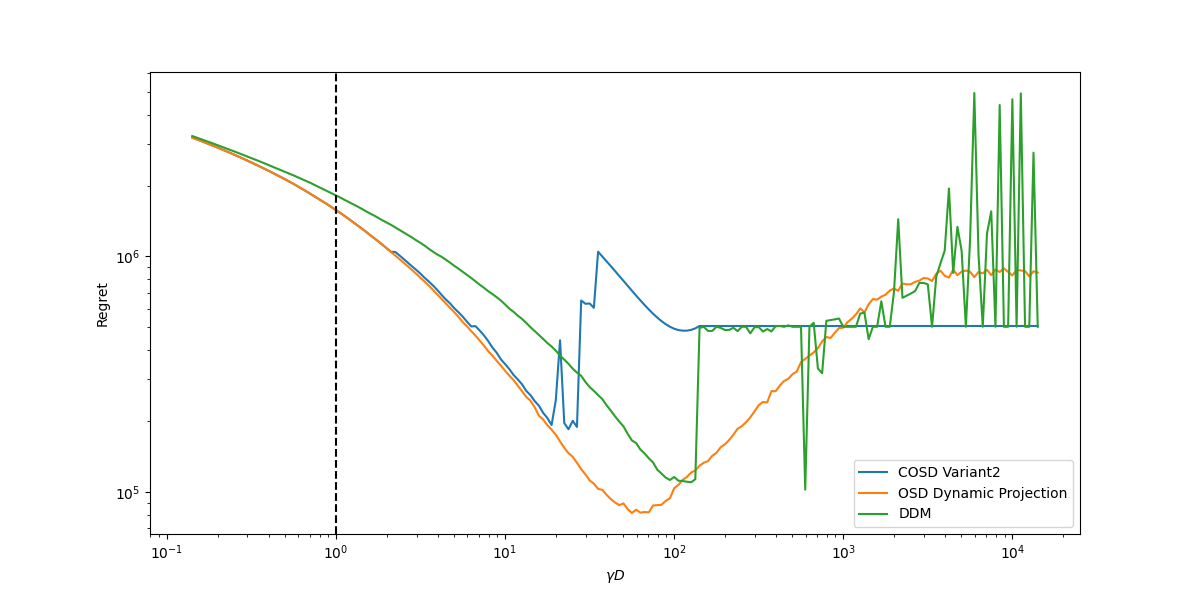

In [13]:
plt.figure(figsize=(12,6))

results = cum_losses[:,1:len(list_gamma)+1,-1]-cum_losses[0,0,-1]
plt.loglog(list_gamma*diameter,np.mean(results,axis=0), label="COSD Variant2")
plt.fill_between(list_gamma*diameter, np.mean(results,axis=0)-np.std(results,axis=0), np.mean(results,axis=0)+np.std(results,axis=0), alpha=0.3)

results = cum_losses[:,len(list_gamma)+1:2*len(list_gamma)+1,-1]-cum_losses[0,0,-1]
plt.loglog(list_gamma*diameter,np.mean(results,axis=0), label="OSD Dynamic Projection")
plt.fill_between(list_gamma*diameter, np.mean(results,axis=0)-np.std(results,axis=0), np.mean(results,axis=0)+np.std(results,axis=0), alpha=0.3)

results = cum_losses[:,2*len(list_gamma)+1:3*len(list_gamma)+1,-1]-cum_losses[0,0,-1]
plt.loglog(list_gamma*diameter,np.mean(results,axis=0), label="DDM")
plt.fill_between(list_gamma*diameter, np.mean(results,axis=0)-np.std(results,axis=0), np.mean(results,axis=0)+np.std(results,axis=0), alpha=0.3)

plt.axvline(gamma*diameter,linestyle="--",color="black")
plt.xlabel(r"$\gamma D$")
plt.ylabel("Regret")
plt.legend()
#plt.text(gamma*diameter+0.0001, plt.gca().get_ylim()[0]+0.01*plt.gca().get_ylim()[1], r"$\rho$", fontsize=12)
plt.show()

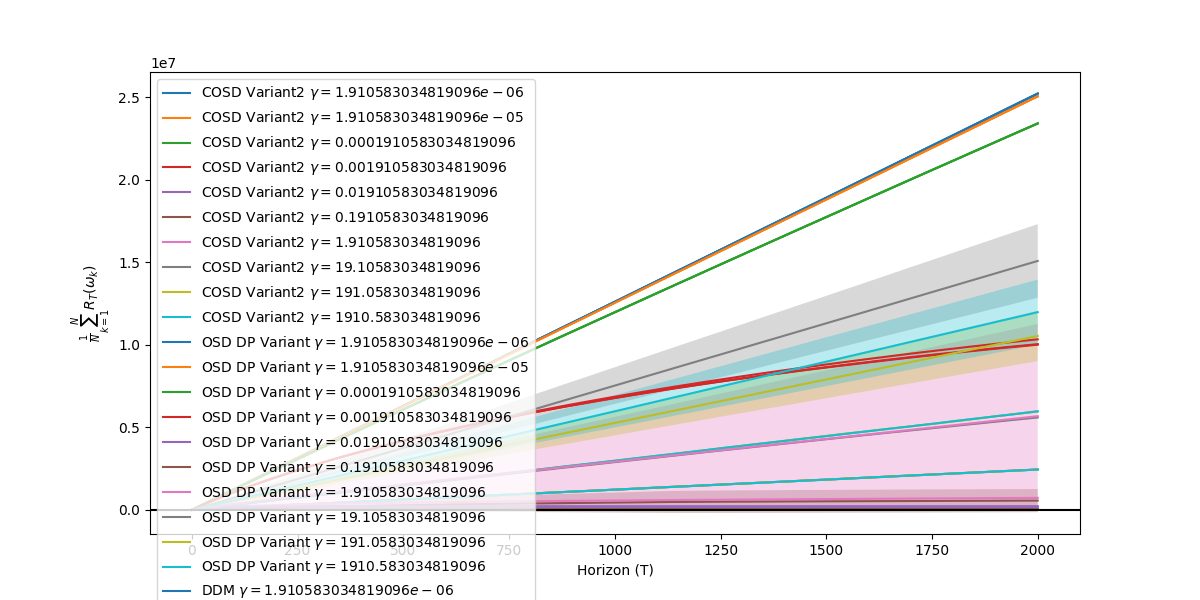

In [ ]:
plt.figure(figsize=(12,6))
for i in range(nb_algs) :
    y = np.mean(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0)
    std = np.std(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0)
    plt.plot(horizons, y,label=algs[i])
    plt.fill_between(horizons, y-std,y+std,alpha=0.3)
plt.axhline(0,color="k")
#plt.plot(horizons,np.sqrt(horizons)*D/2*np.sqrt(2/np.pi),"--",color="k",label="theoretical equivalent")
#plt.plot(horizons,np.sqrt(horizons)*D/(4*np.sqrt(2)),"x",color="k",label="theoretical lower bound")
plt.ylabel(r"$\frac{1}{N}\sum_{k=1}^N R_T(\omega_k)$")
plt.xlabel("Horizon (T)")
plt.legend(loc="upper left")
plt.show()